Regression and Stochastic Gradient Descent
===================================



Regression consists in finding a model $f$ that depends on parameters $\theta$ and that verifies $f(\theta, x_i) = y_i$ for a given set of $(x_i, y_i)_{i=1..n}$. 

Regression can be recast as an optimization problem, for example by minimizing the loss: 

\begin{equation}
L = \sum_i \| y_i - f(\theta, x_i) \|_2^2
\end{equation}


In [1]:
from __future__ import print_function
import numpy as np
from matplotlib import pyplot
import torch
import numpy as np

# Regressing between 2 squares

Let's make 2 sets of points, both on a square, such that there is an affine transformation between them

In [98]:
def gen_2squares(n): 
    a = np.random.rand(n) * 2 * np.pi
    x = np.vstack((np.cos(a), np.sin(a)))
    x = x / np.linalg.norm(x, axis=0, ord=1)
    y = np.vstack((np.cos(a + np.pi / 4), np.sin(a + np.pi / 4)))
    y = y / np.linalg.norm(y, axis=0, ord=np.inf)
    y[0] += 3
    x += np.random.randn(*x.shape) * 0.02
    y += np.random.randn(*x.shape) * 0.02
    return x.T, y.T
    

In [111]:
x, y = gen_2squares(200)

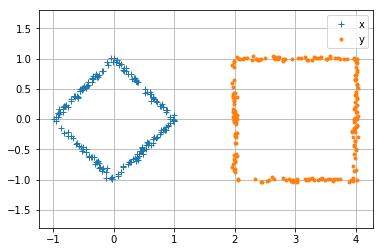

In [112]:
pyplot.plot(x[:, 0], x[:, 1], '+', label='x')
pyplot.plot(y[:, 0], y[:, 1], '.', label='y')
pyplot.axis('equal')
pyplot.legend()
pyplot.grid()

The affine transformation: the parameters are a 2x2 matrix and a 2D translation. We stack them together in a 2x3 matrix


In [113]:
def f(theta, x):
    return torch.matmul(x, theta[:2, :]) + theta[2, :]

In [125]:
xt = torch.from_numpy(x.astype('float32'))
yt = torch.from_numpy(y.astype('float32'))

# starting point
theta = torch.tensor([
    [1., 0.], 
    [0., 1.], 
    [0., 0.]
])

# set the learning rate
learning_rate = 0.5
points = []
for it in range(20):    
    
    # we will need a gradient wrt. x
    theta.requires_grad = True
    
    # call the function, record dependencies for the gradient
    y_cur = f(theta, xt)
    err = ((y_cur - yt) ** 2).mean()
    
    points.append(y_cur.detach().numpy())
    print(err.item())
    
    # compute gradients
    err.backward()    
    
    # update current solution
    theta = theta.data - learning_rate * theta.grad


4.84595012665
1.31714725494
0.406178712845
0.157095968723
0.0795908048749
0.0494764894247
0.0344110578299
0.0253612156957
0.0193956438452
0.0153083028272
0.0124661028385
0.0104785775766
0.0090855685994
0.0081082014367
0.00742202997208
0.00694006728008
0.0066013969481
0.00636332156137
0.00619589630514
0.00607810961083


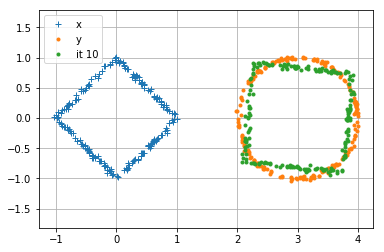

In [126]:
pyplot.plot(x[:, 0], x[:, 1], '+', label='x')
pyplot.plot(y[:, 0], y[:, 1], '.', label='y')
it = 10
y2 = points[it]
pyplot.plot(y2[:, 0], y2[:, 1], '.', label='it %d' % it)
pyplot.axis('equal')
pyplot.legend()
pyplot.grid()

# Stochastic gradient descent

The optimization sees points in "mini-batches", ie. the sum $\sum_i \| y_i - f(\theta, x_i) \|_2^2$ is not computed as a whole but for a subset of points. The points are visited in a random order. 

In [124]:
xt = torch.from_numpy(x.astype('float32'))
yt = torch.from_numpy(y.astype('float32'))

# starting point
theta = torch.tensor([
    [1., 0.], 
    [0., 1.], 
    [0., 0.]
])

# set the learning rate
learning_rate = 0.5
objectives = []
n = xt.shape[0]

for it in range(20):        
    # random order 
    perm = torch.randperm(n)
    errs = []
    for i0 in range(0, n, 10):
        
        # i0 is called the batch size
        theta.requires_grad = True
        
        # we handle this subset of points (a minibatch)
        xbatch = xt[perm[i0 : i0 + 10]]
        ybatch = yt[perm[i0 : i0 + 10]]
    
        # compute the partial loss on this mini-batch
        y_cur_batch = f(theta, xbatch)
        err = ((y_cur_batch - ybatch) ** 2).mean()
        errs.append(err.item())
    
        # compute gradients
        err.backward()    

        # update current solution
        theta = theta.data - learning_rate * theta.grad

    print(np.mean(errs))

0.3586074177641422
0.006233111734036356
0.006078910653013736
0.006105066643794998
0.006191927869804203
0.006216824194416404
0.006077148858457804
0.006098527158610523
0.0059087547240778806
0.006068276707082987
0.006209121563006193
0.006188580417074263
0.006210151687264442
0.006288293958641588
0.006186149478890002
0.006108289514668286
0.006124264246318489
0.006077379686757922
0.006292834295891225
0.006240854831412434


What do we observe in terms of learning speed?

# Regressing between a square and... a circle!

In [118]:
def gen_square_circle(n): 
    n4 = int(n/4)
    a = np.random.rand(n) * 2 * np.pi
    x = np.vstack((np.cos(a), np.sin(a)))
    x = x / np.linalg.norm(x, axis=0, ord=1)
    y = np.vstack((np.cos(a + np.pi / 4), np.sin(a + np.pi / 4)))
    y = y / np.linalg.norm(y, axis=0, ord=2)
    y[0] += 3
    x += np.random.randn(*x.shape) * 0.02
    y += np.random.randn(*x.shape) * 0.02
    return x.T, y.T
    

In [119]:
x, y = gen_square_circle(200)

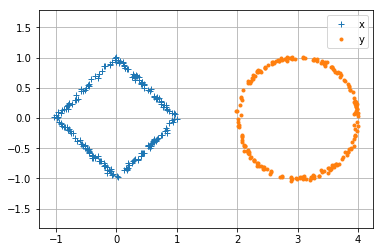

In [123]:
pyplot.plot(x[:, 0], x[:, 1], '+', label='x')
pyplot.plot(y[:, 0], y[:, 1], '.', label='y')
pyplot.axis('equal')
pyplot.legend()
pyplot.grid()

Obviously we need a non-linear model. One of the great principles of neural nets is that we have the combination of:

- large linear transformations: fast to evaluate and lots of parameters

- scalar non-linearities.

The combination has a great expressive power: almost all mappings can be expressed with it. Let's make a 2-layer neural net to find a reasonable mapping.